In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

In [2]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split

# #PERCORSO DATASET
# dataset_dir = "dataset_orchidee"
# output_dir = "dataset_split"

# #DATI DA USARE PER IL TEST
# test_size = 0.3

# # Creazione delle directory di output
# for split in ["train", "test"]:
#     os.makedirs(os.path.join(output_dir, split), exist_ok=True)

# # Itera su tutte le classi (sottodirectory di dataset_dir)
# for class_name in os.listdir(dataset_dir):
#     class_path = os.path.join(dataset_dir, class_name)
#     if not os.path.isdir(class_path):
#         continue  

#     # Creazione delle directory di output per ogni classe
#     train_class_dir = os.path.join(output_dir, "train", class_name)
#     test_class_dir = os.path.join(output_dir, "test", class_name)
#     os.makedirs(train_class_dir, exist_ok=True)
#     os.makedirs(test_class_dir, exist_ok=True)

#     # Lista dei file per la classe corrente
#     files = os.listdir(class_path)
    
#     # Divisione in train e test
#     train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)
    
#     # Copia dei file nella directory corrispondente
#     for file in train_files:
#         shutil.copy(os.path.join(class_path, file), os.path.join(train_class_dir, file))
#     for file in test_files:
#         shutil.copy(os.path.join(class_path, file), os.path.join(test_class_dir, file))

# print("Dataset splittato con successo!")

In [3]:
from torchvision import transforms, datasets
from torch.utils.data import dataloader
from torchvision.transforms import transforms

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),  
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(20),      
#     transforms.RandomResizedCrop(224), 
#     transforms.ToTensor(),
#     #QUESTI SONO I VALORI MEDI PER IL MODELLO MOBILENET 
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# ])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(10),    
    transforms.RandomResizedCrop(size=(224, 224), antialias=True),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



#DATASET
train_dataset = datasets.ImageFolder('dataset_split/train', transform=transform)
test_dataset = datasets.ImageFolder('dataset_split/test', transform=transform)

#DATALOADER
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 875
Test dataset size: 377


In [4]:
#RETE MOBILENET PREADDESTRATA
mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

#SCONGELAMENTO DEI PESI DEL FEAUTURE EXTRACTOR(lo faccio perchè il datasset è molto diverso di quello sul quale il modello è addestrato)
for param in mobilenet.features.parameters():
    param.requires_grad = True

#NUMERO TOTALE DELLE CLASSI
dataset_dir = "dataset_orchidee"
num_classes = len(os.listdir(dataset_dir))


#MODIFICA DEL CLASSIFICATORE PER RENDERLO MULTICLASSE
num_features = mobilenet.last_channel
mobilenet.classifier = nn.Sequential(                                
    nn.Linear(num_features, num_classes),   
)

In [5]:
#APPLICAZIONE DELLA FUNZIONE DI PERDITA CROSSENTROPY
criterion = nn.CrossEntropyLoss()
#APPLICAZIONE DELLA FUNZIONE DI OTTIMIZZAZIONE ADAM
optimizer = optim.Adam(mobilenet.classifier.parameters(), lr=0.001)
#SALVATAGGIO DEI PARAMETRI SUL DISPOSITIVO CORRENTE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mobilenet.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [6]:
num_epochs = 10
for epoch in range(num_epochs):
    mobilenet.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = mobilenet(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        torch.cuda.empty_cache()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/10, Loss: 1.5538
Epoch 2/10, Loss: 1.1262
Epoch 3/10, Loss: 0.9890
Epoch 4/10, Loss: 0.8512
Epoch 5/10, Loss: 0.8113
Epoch 6/10, Loss: 0.7215
Epoch 7/10, Loss: 0.7060
Epoch 8/10, Loss: 0.6662
Epoch 9/10, Loss: 0.6451
Epoch 10/10, Loss: 0.6537


In [7]:
mobilenet.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on validation set: {100 * correct / total:.2f}%")

Accuracy on validation set: 79.84%


In [8]:
torch.save(mobilenet.state_dict(), "mobilenet_finetuned.pth")

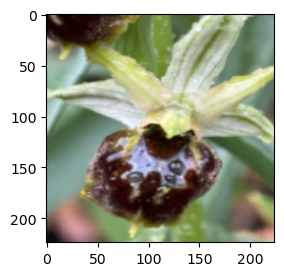

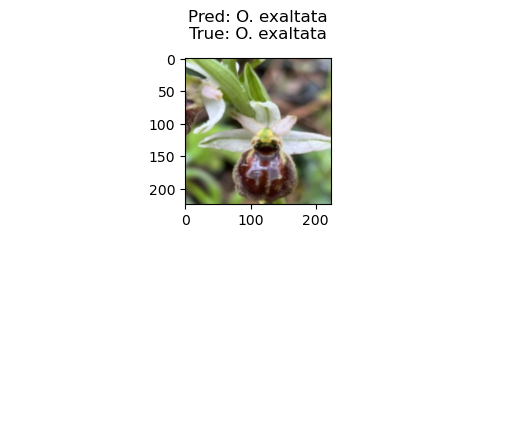

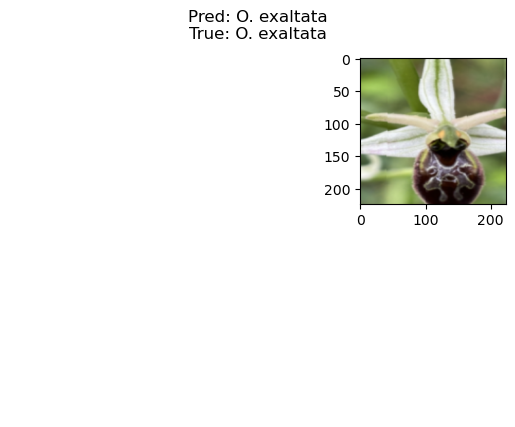

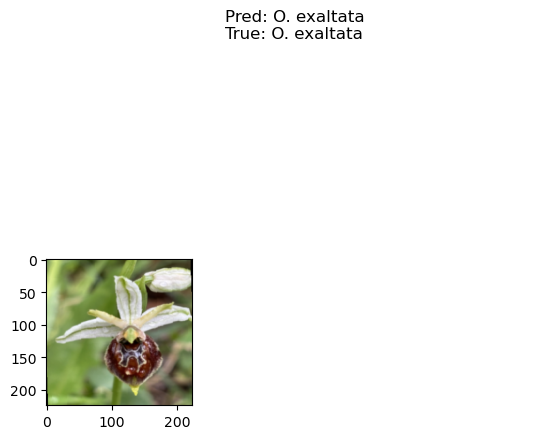

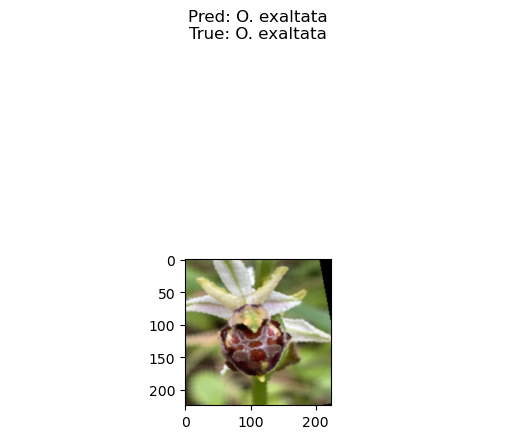

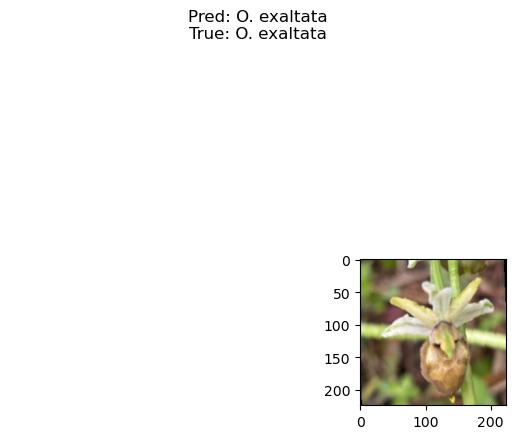

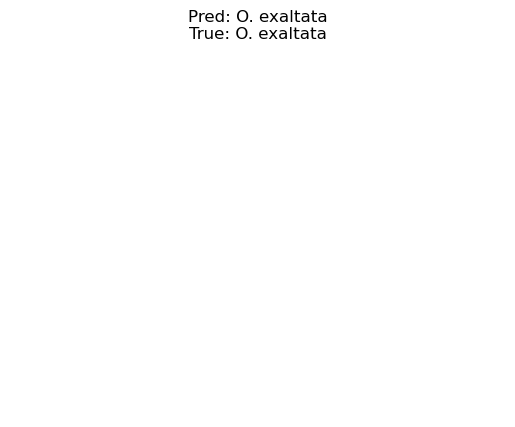

In [9]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

outputs = mobilenet(images)
_, predicted = torch.max(outputs, 1)

plt.figure(figsize=(10, 10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    imshow(images[i].cpu())
    plt.title(f'Pred: {train_dataset.classes[predicted[i]]}\nTrue: {train_dataset.classes[labels[i]]}')
    plt.axis('off')
plt.show()
